# AdaBoost Implementation

## Data Structure

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import mode

In [2]:
class AdaBoost():
    def __init__(self, num_classifiers, max_depth, num_samples):
        self.num_classifiers = num_classifiers
        self.classifiers = []
        self.classifier_weights = np.zeros(self.num_classifiers)
        self.max_depth = max_depth
        self.sample_weights = np.full(num_samples, 1/num_samples)
        
    def predict(self, samples):
        num_samples = samples.shape[0]
        preds = np.zeros((len(self.classifiers), num_samples))
        for i, clf in enumerate(self.classifiers):
            preds[i] = clf.predict(samples)
        majority_votes = mode(preds, axis=0)[0].flatten()
        return majority_votes
    
    def predict_proba(self, samples):
        num_samples = samples.shape[0]
        preds = np.zeros((len(self.classifiers), num_samples))
        for i, clf in enumerate(self.classifiers):
            preds[i] = clf.predict_proba(samples)[:, 1]
        average_votes = np.average(preds, axis=0, weights=self.classifier_weights[:len(self.classifiers)])
        return average_votes
    
    def update_sample_weights(self, misclassified, alpha):
        self.sample_weights *= np.exp((2 * misclassified - 1) * alpha)
        self.sample_weights /= np.sum(self.sample_weights)
        
    def fit(self, samples, targets):
        for i in range(self.num_classifiers):
            clf = DecisionTreeClassifier(max_depth=self.max_depth)
            clf.fit(samples, targets, sample_weight=self.sample_weights)
            preds = clf.predict(samples)
            misclassified = preds != targets
            error = np.sum(self.sample_weights * misclassified)
            if error == 0:
                error = 1e-10
            alpha = 0.5 * np.log((1 - error) / error)
            self.classifiers.append(clf)
            self.classifier_weights[len(self.classifiers) - 1] = alpha
            self.update_sample_weights(misclassified, alpha)
        

## Functions to calculate errors across estimators

In [3]:
from sklearn.metrics import accuracy_score

In [1]:
def get_errors_across_estimators_rf(model, X_train, X_test, y_train, y_test):
    train_errors = []
    test_errors = []
    for i in range(1, model.n_estimators + 1):
        model = RandomForestClassifier(n_estimators=i, max_depth=model.max_depth, random_state=42)
        model.fit(X_train, y_train)
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)
        train_errors.append(1 - accuracy_score(y_train, train_preds))
        test_errors.append(1 - accuracy_score(y_test, test_preds))
    return train_errors, test_errors

In [5]:
def get_errors_across_estimators_ab(model, X_train, X_test, y_train, y_test):
    train_errors = []
    test_errors = []
    for i in range(1, model.n_estimators + 1):
        model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=model.base_estimator.max_depth),
                                   n_estimators=i, random_state=42)
        model.fit(X_train, y_train)
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)
        train_errors.append(1 - accuracy_score(y_train, train_preds))
        test_errors.append(1 - accuracy_score(y_test, test_preds))
    return train_errors, test_errors

In [6]:
def get_errors_across_estimators_my_ab(model, X_train, X_test, y_train, y_test):
    train_errors = []
    test_errors = []
    for i in range(1, model.num_classifiers + 1):
        model = AdaBoost(i, model.max_depth, X_train.shape[0])
        model.fit(X_train, y_train)
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)
        train_errors.append(1 - accuracy_score(y_train, train_preds))
        test_errors.append(1 - accuracy_score(y_test, test_preds))
    return train_errors, test_errors

## Function to calcuate errors across estimators for varied tree depth

In [7]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [2]:
def get_estimator_errors_across_depth(tree_depths, n_classifiers, X_train, X_test, y_train, y_test):
    rf_train_errors_list = []
    rf_test_errors_list = []
    ab_train_errors_list = []
    ab_test_errors_list = []
    my_ab_train_errors_list = []
    my_ab_test_errors_list = []

    for depth in tree_depths:
        rf = RandomForestClassifier(n_estimators=n_classifiers, max_depth=depth, random_state=42)
        rf.fit(X_train, y_train)
        train_errors, test_errors = get_errors_across_estimators_rf(rf, X_train, X_test, y_train, y_test)
        rf_train_errors_list.append(train_errors)
        rf_test_errors_list.append(test_errors)

        ab = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=depth),
                                n_estimators=n_classifiers, random_state=42)
        ab.fit(X_train, y_train)
        train_errors, test_errors = get_errors_across_estimators_ab(ab, X_train, X_test, y_train, y_test)
        ab_train_errors_list.append(train_errors)
        ab_test_errors_list.append(test_errors)
        
        my_ab = AdaBoost(n_classifiers, depth, X_train.shape[0])
        my_ab.fit(X_train, y_train)
        train_errors, test_errors = get_errors_across_estimators_my_ab(my_ab, X_train, X_test, y_train, y_test)
        my_ab_train_errors_list.append(train_errors)
        my_ab_test_errors_list.append(test_errors)
        
    return rf_train_errors_list, rf_test_errors_list, ab_train_errors_list, ab_test_errors_list, my_ab_train_errors_list, my_ab_test_errors_list

## Function to plot errors acorss estimators for varied tree depth

In [9]:
import matplotlib.pyplot as plt

In [10]:
def plot_estimator_errors_across_depth(title, rf_data, ab_data, my_ab_data, tree_depths, n_classifiers):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), sharex=True, sharey=True)
    fig.suptitle(title)
    
    for i, ax_row in enumerate(axes):
        ax_row[0].plot(range(1, n_classifiers + 1), rf_data[i], linestyle='-', color='g')
        ax_row[0].set_xlabel('Number of Estimators')
        ax_row[0].set_ylabel('Error Rate')
        ax_row[0].set_title(f'Random Forest, depth {tree_depths[i]}')

        ax_row[1].plot(range(1, n_classifiers + 1), ab_data[i], linestyle='-', color='r')
        ax_row[1].set_xlabel('Number of Estimators')
        ax_row[1].set_ylabel('Error Rate')
        ax_row[1].set_title(f'native AdaBoost, depth {tree_depths[i]}')
        
        ax_row[2].plot(range(1, n_classifiers + 1), my_ab_data[i], linestyle='-', color='b')
        ax_row[2].set_xlabel('Number of Estimators')
        ax_row[2].set_ylabel('Error Rate')
        ax_row[2].set_title(f'My AdaBoost, depth {tree_depths[i]}')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## Breast cancer dataset

In [11]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [12]:
tree_depths = [1, 2, 4]
n_classifiers = 50

In [13]:
bcds = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(bcds.data, bcds.target, test_size=0.2, random_state=42)

In [ ]:
rf_train_err, rf_test_err, ab_train_err, ab_test_err, my_ab_train_err, my_ab_test_err = get_estimator_errors_across_depth(
    tree_depths, n_classifiers, X_train, X_test, y_train, y_test)

In [15]:
title = 'Training error on Breast Cancer Dataset for Random Forest, native AdaBoost, and my AdaBoost'

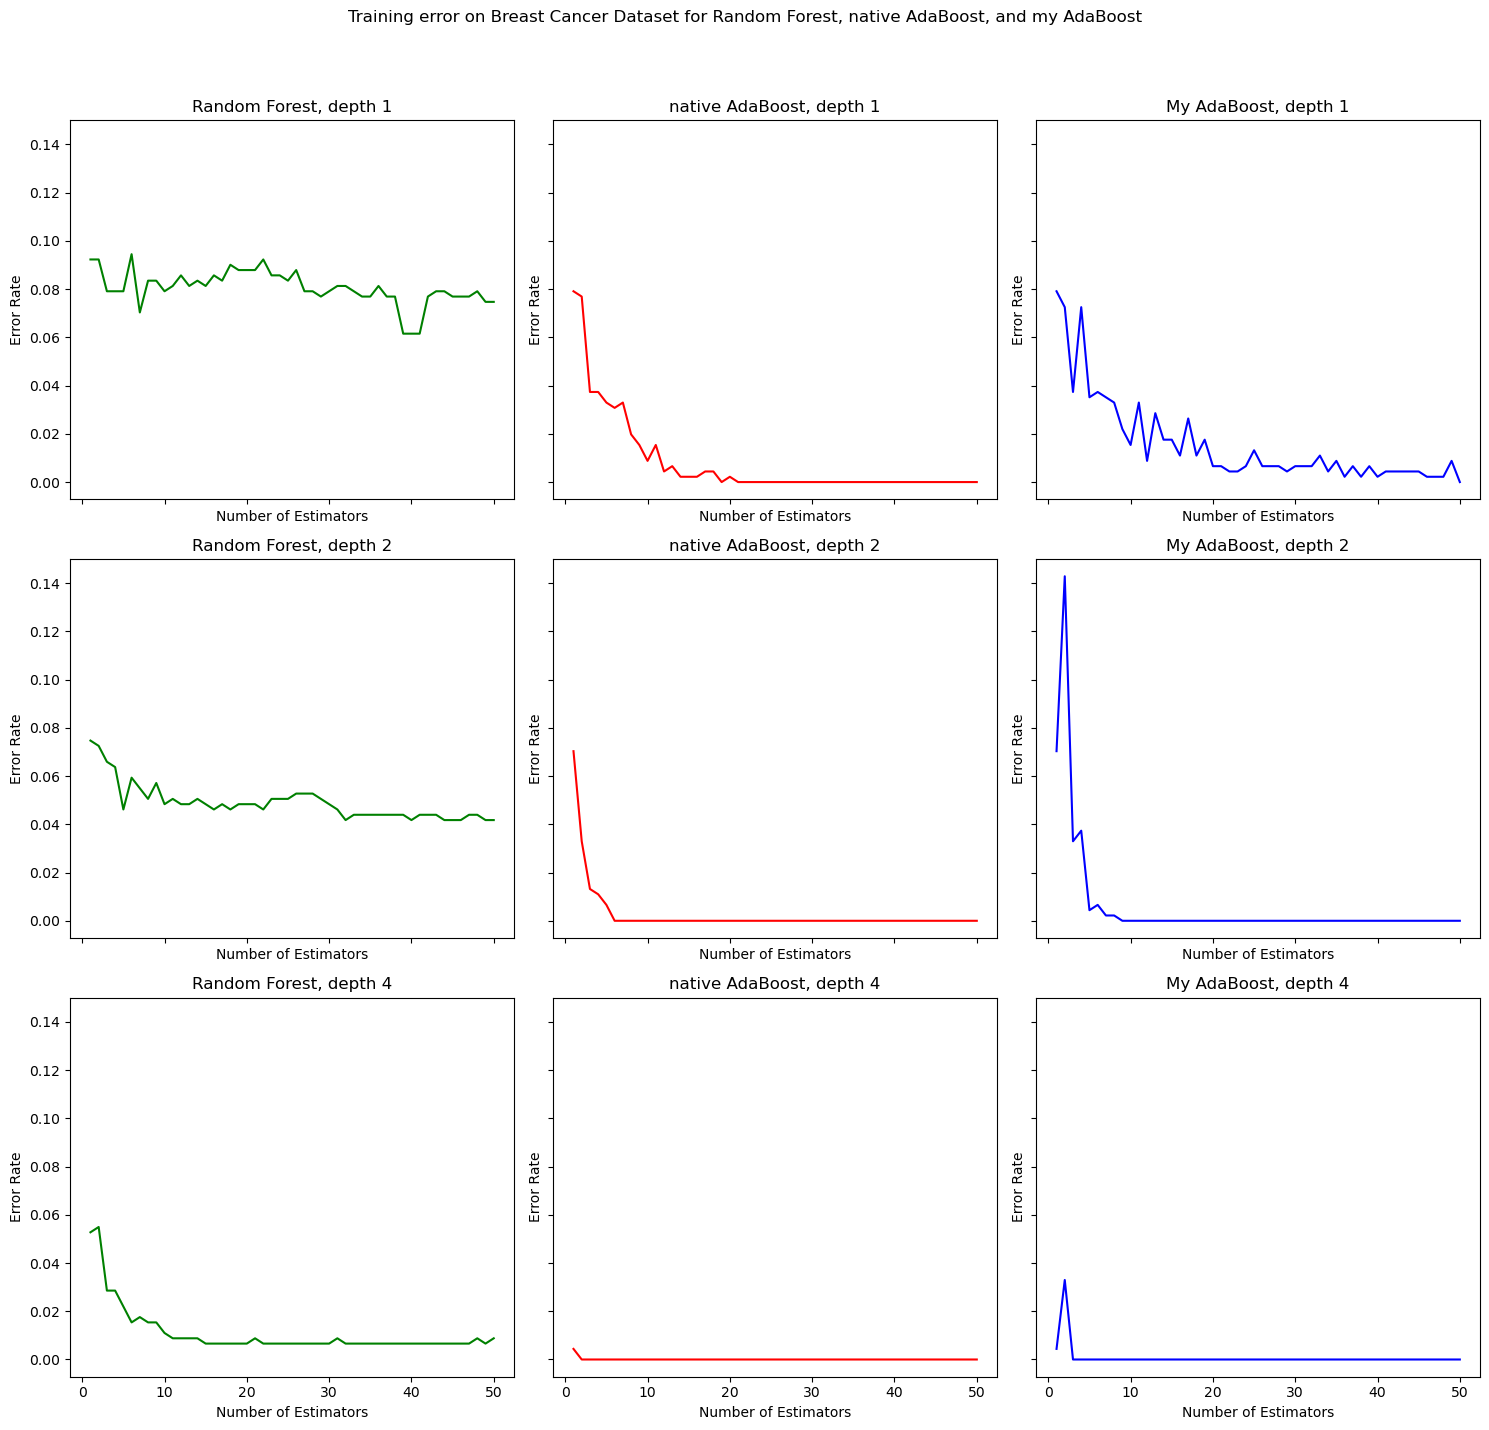

In [16]:
plot_estimator_errors_across_depth(title, rf_train_err, ab_train_err, my_ab_train_err, tree_depths, n_classifiers)

In [17]:
title = 'Test error on Breast Cancer Dataset for Random Forest, native AdaBoost, and my AdaBoost'

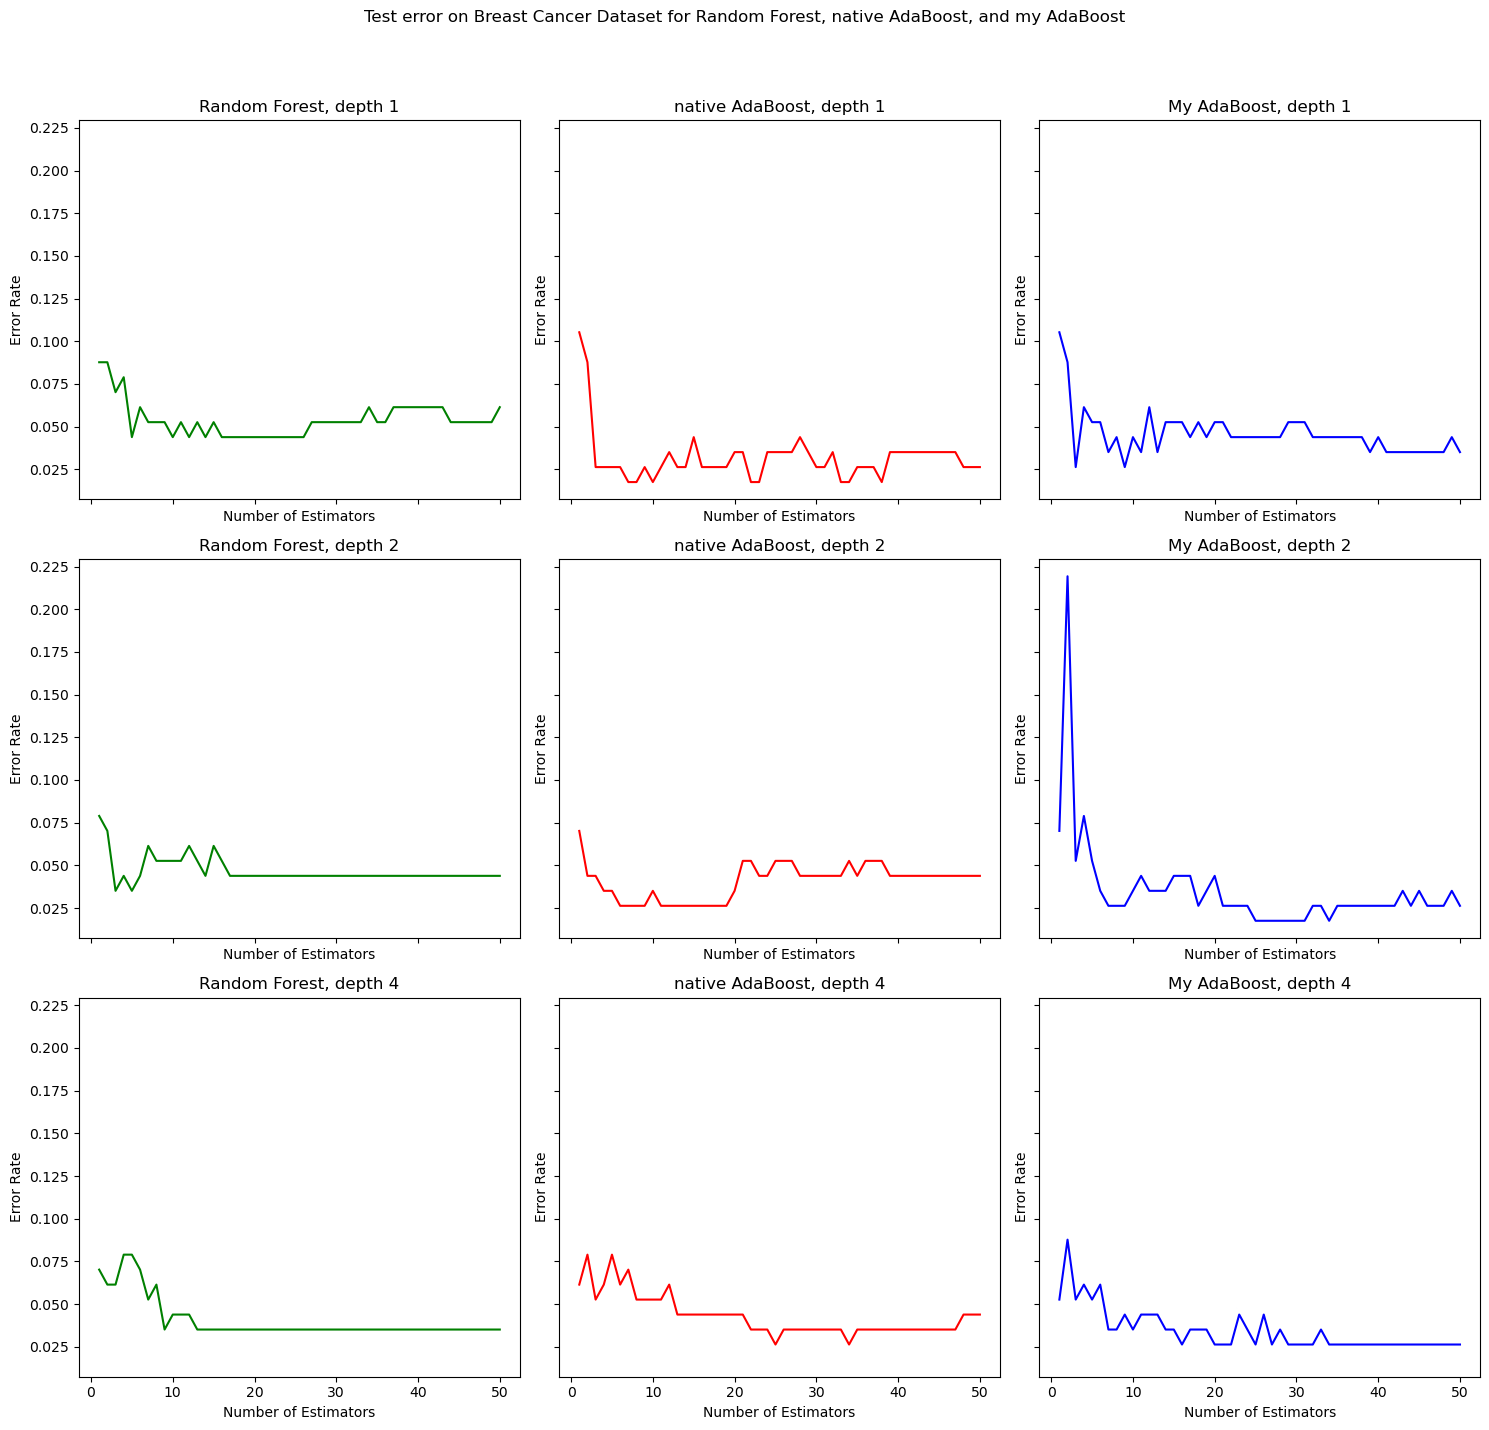

In [18]:
plot_estimator_errors_across_depth(title, rf_test_err, ab_test_err, my_ab_test_err, tree_depths, n_classifiers)

## Diabetes dataset

In [19]:
from sklearn.datasets import load_diabetes

In [20]:
tree_depths = [1, 2, 4]
n_classifiers = 50

In [21]:
dds = load_diabetes()
threshold = 140.5
dds_target_binary = (dds.target > threshold).astype(int)
X_train, X_test, y_train, y_test = train_test_split(dds.data, dds_target_binary, test_size=0.2, random_state=42)

In [ ]:
rf_train_err, rf_test_err, ab_train_err, ab_test_err, my_ab_train_err, my_ab_test_err = get_estimator_errors_across_depth(
    tree_depths, n_classifiers, X_train, X_test, y_train, y_test)

In [23]:
title = 'Training error on Diabetes Dataset for Random Forest, native AdaBoost, and my AdaBoost'

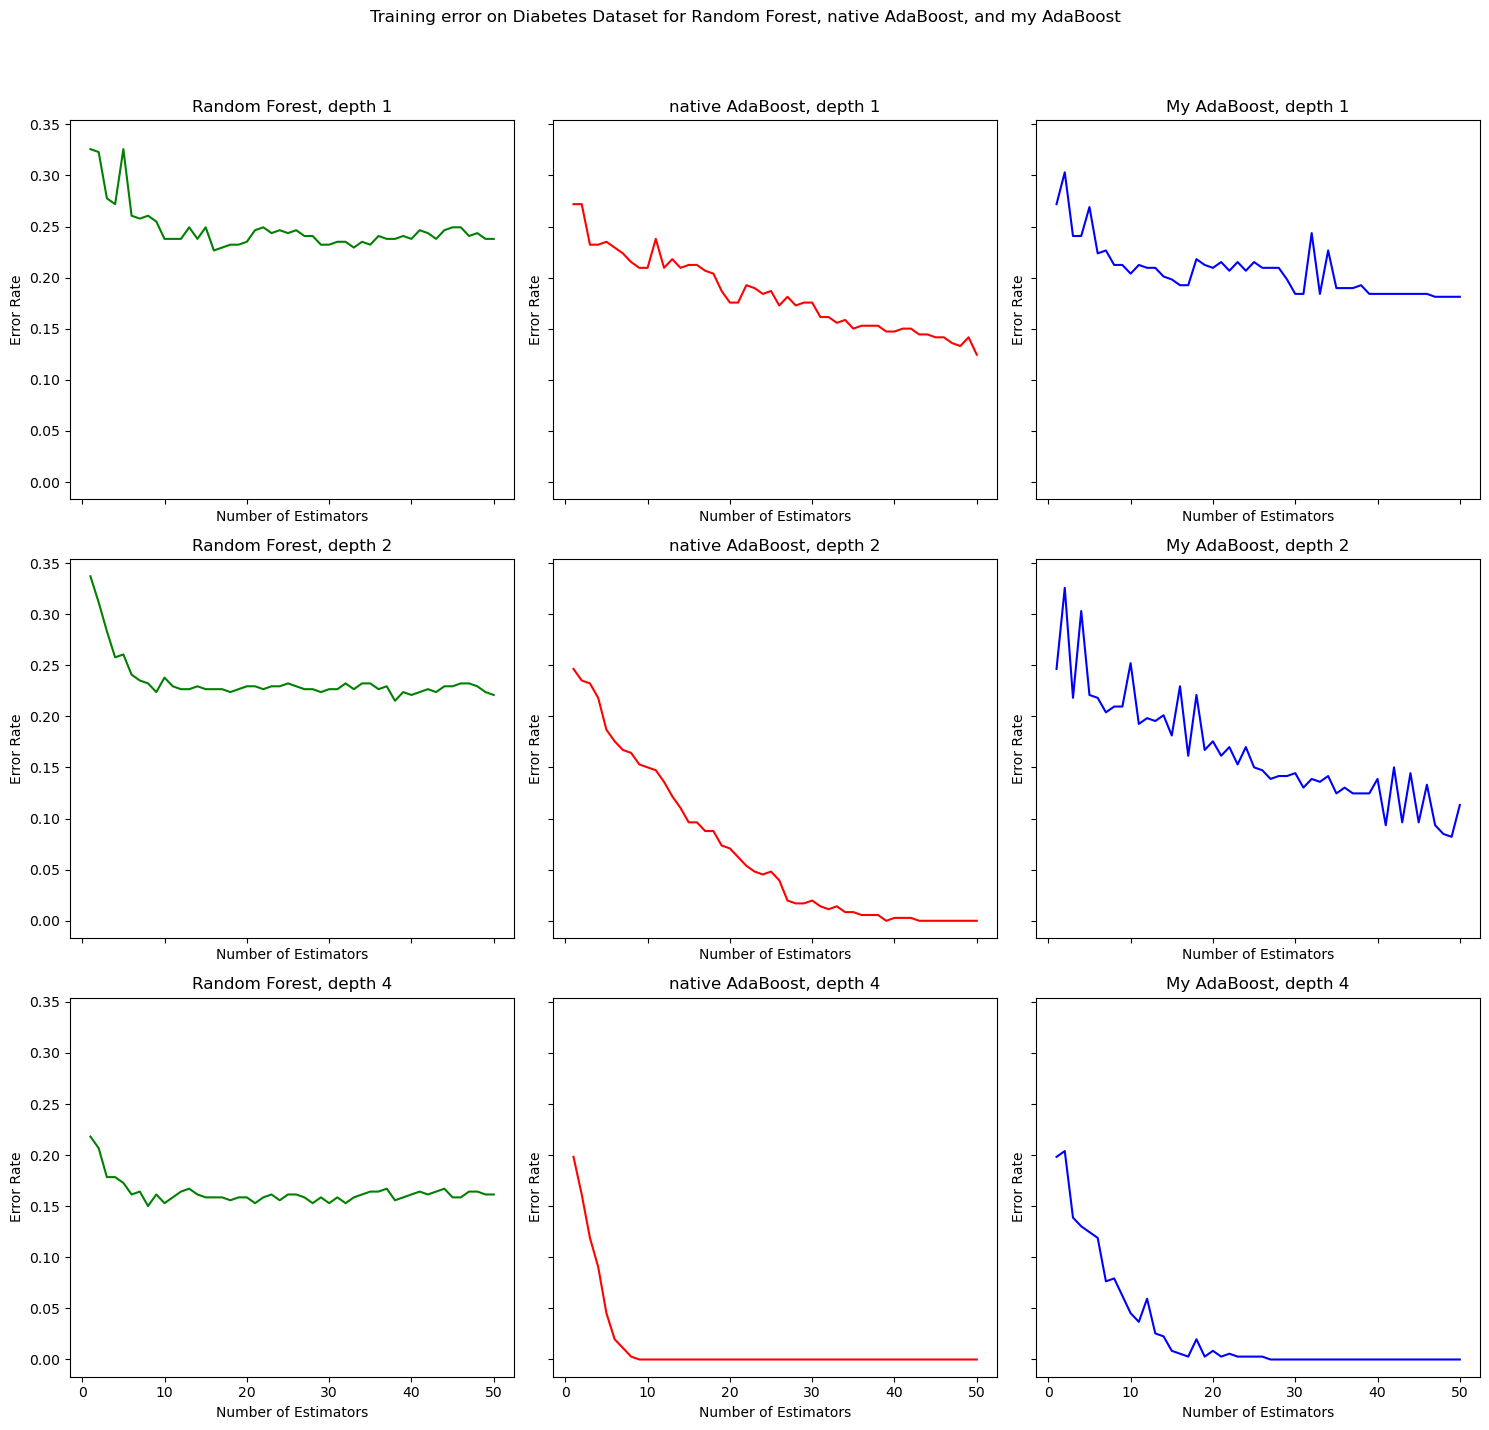

In [24]:
plot_estimator_errors_across_depth(title, rf_train_err, ab_train_err, my_ab_train_err, tree_depths, n_classifiers)

In [25]:
title = 'Test error on Diabetes Dataset for Random Forest, native AdaBoost, and my AdaBoost'

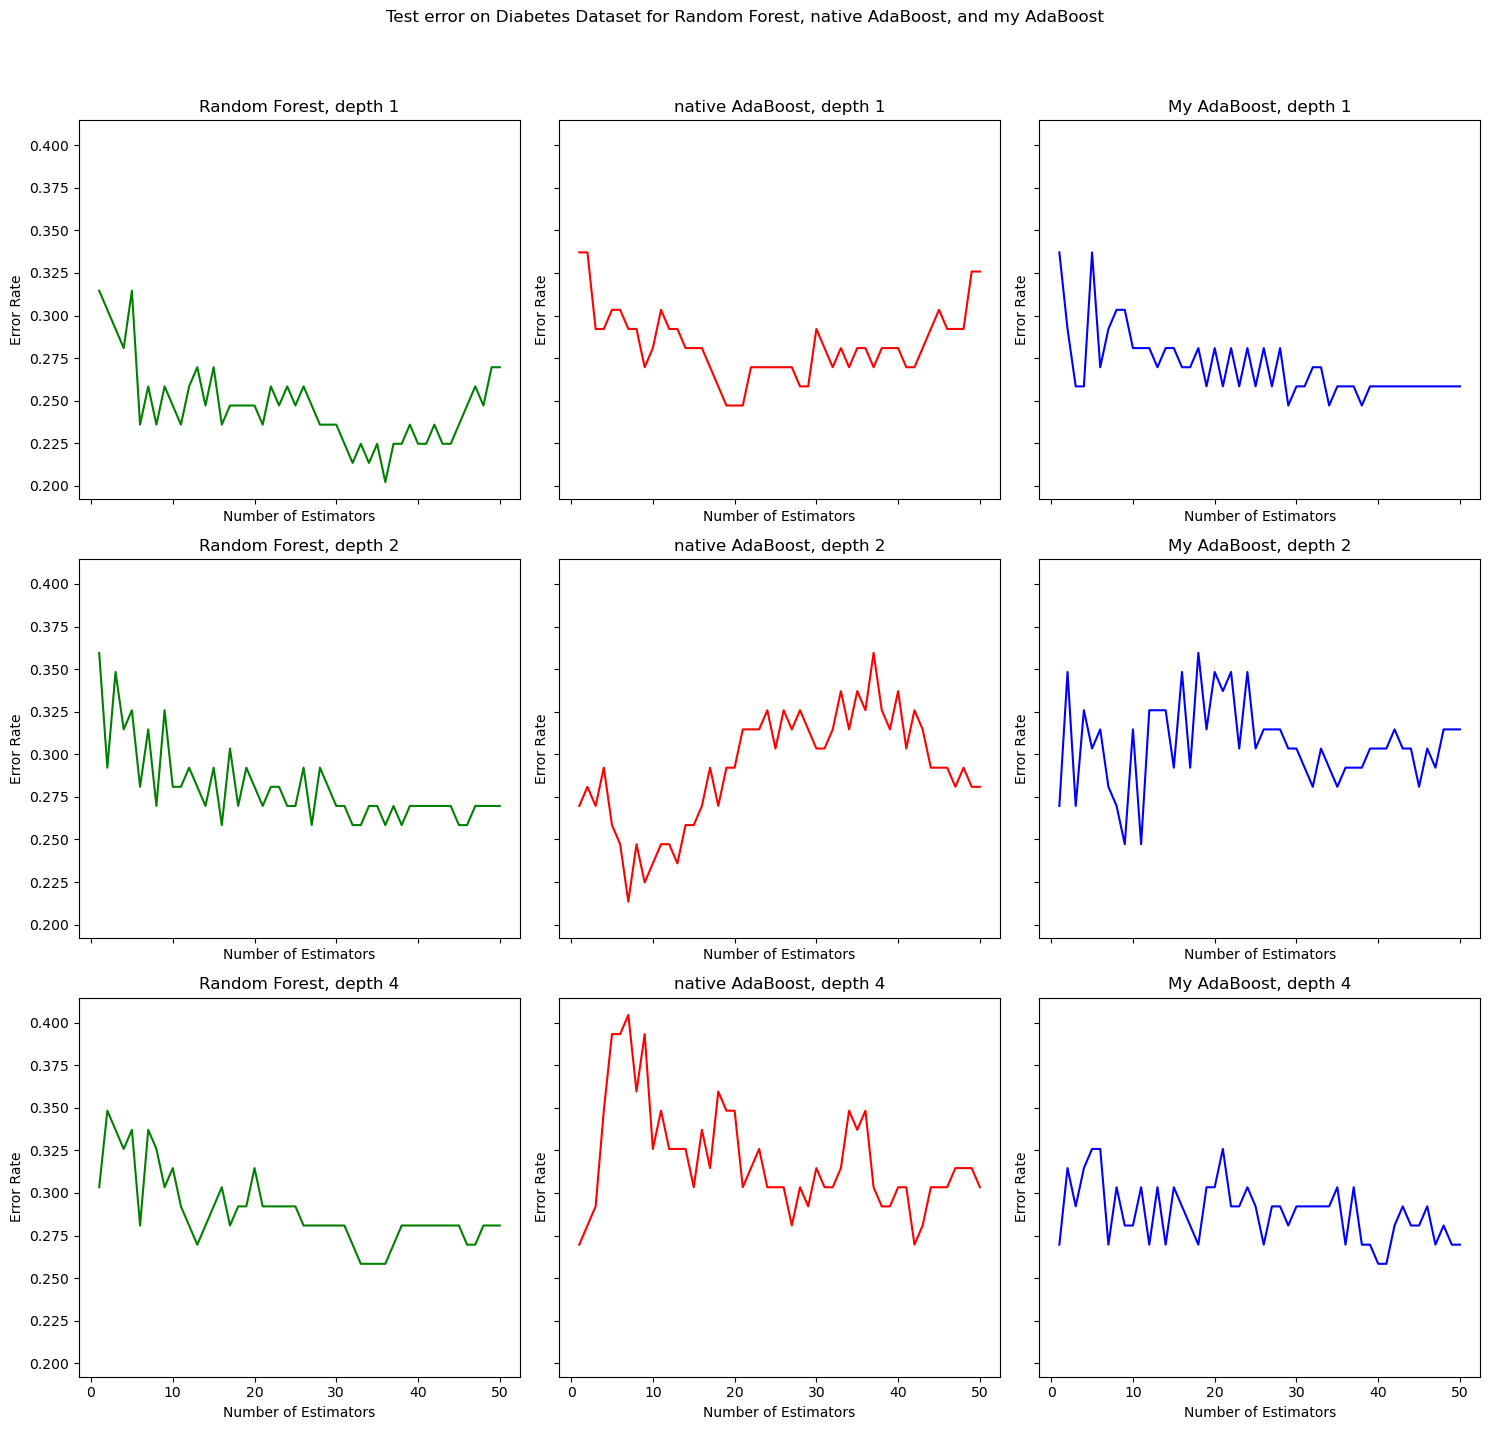

In [26]:
plot_estimator_errors_across_depth(title, rf_test_err, ab_test_err, my_ab_test_err, tree_depths, n_classifiers)

## Analysis

My AdaBoost implementation overall performs very similar to the native sklearn AdaBoostClassifier.

Training: The random forest has a signifcantly harder time achieving low error during the training phase as compared with both native ada boost and my ada boost. This is likley due to the error correction stratgey of ada boost and how sucessive models in the ensemble train on samples the other models struggled on, leading to a low training error. Random forests however build each decsion tree independently, preventing a dramatic convergence of training error towards zero
More estimators leads to lower error during training, and more depth leads to faster convergence. This is simply due to a more coplex model can fit the training data it see more precisely.

Testing: The random forest is able to achive lower error during the testing phase than native ada boost and my ada boost. This great generalizability is likely due to the fact that averaging multiple independent trees allows them to cover for the mistakes of others. Training on different sets of data helps random forests not overfit, which is something that can happen with ada boost as each model is dependent on how the previous model performed. Ada boost will repeatedly train on the same data if previous models struggle with certain samples, possibly causing an overall overfitted model.
There is a point of diminishing returns or even a negative effect on test error when it comes to increasing the number of estimators and increasing depth. This shows a more complex model can struggle generalzing to data it has not seen before.